In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn import ensemble
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance

from matplotlib import pyplot as plt
%matplotlib inline


Interpreting random forests
============================

Interpreting random forests



Data on wages
--------------

We use the same data as in the linear-model notebook



In [2]:
# Download the data if it does not exists
if not os.path.exists('wages.txt'):
    from urllib.request import urlretrieve
    # Download the file if it is not present
    urlretrieve('http://lib.stat.cmu.edu/datasets/CPS_85_Wages',
                'wages.txt')

# Give names to the columns
names = [
    'EDUCATION: Number of years of education',
    'SOUTH: 1=Person lives in South, 0=Person lives elsewhere',
    'SEX: 1=Female, 0=Male',
    'EXPERIENCE: Number of years of work experience',
    'UNION: 1=Union member, 0=Not union member',
    'WAGE: Wage (dollars per hour)',
    'AGE: years',
    'RACE: 1=Other, 2=Hispanic, 3=White',
    'OCCUPATION: 1=Management, 2=Sales, 3=Clerical, 4=Service, 5=Professional, 6=Other',
    'SECTOR: 0=Other, 1=Manufacturing, 2=Construction',
    'MARR: 0=Unmarried,  1=Married',
]

short_names = [n.split(':')[0] for n in names]
data = pd.read_csv(
    'wages.txt', skiprows=27, skipfooter=6, sep=None,
    header=None, engine='python'
)
data.columns = short_names

# Log-transform the wages, as they typically increase with
# multiplicative factors
data['WAGE'] = np.log10(data['WAGE'])

# take all columns except WAGE to try to predict WAGE
X = data.drop(columns=['WAGE'] + ['RACE', 'OCCUPATION', 'SECTOR'])
y = data['WAGE']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=27
)

Feature importance
----------------------




Interpreting random forests can be done through feature importance: the **Mean Decrease in Impurity**. This index explain how much a feature is used to split a tree. This is also known as the Gini importance.


<AxesSubplot:>

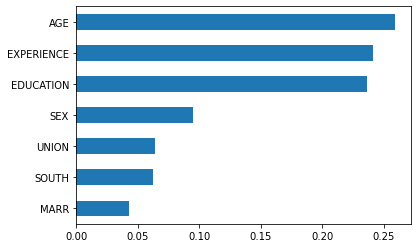

In [3]:
forest = ensemble.RandomForestRegressor(n_estimators=100)
forest.fit(X_train, y_train)

# Visualize the feature importance
importance = pd.Series(
    forest.feature_importances_,
    index=X_train.columns
).sort_values()
importance.plot(kind='barh')

Meaning and Caveats
-----------------------

Also, the impurity-based feature importance ranks the numerical
features to be the most important features. Indeed, many split can
be done on a numerical features while there is at most `n_cat - 1`
splits possible for a categorical feature. As a result, if there is
a non-predictive `random_num` variable in the features, it will be
ranked as the most important one!

This problem stems from two limitations of impurity-based feature importances:

* impurity-based importances are biased towards high cardinality features;
* impurity-based importances are computed on training set statistics and therefore do not reflect the ability of feature to be useful to make predictions that generalize to the test set (when the model has enough capacity).


In [4]:
rng = np.random.RandomState(seed=29)
X_rand = X.copy()
X_rand['random_cat'] = rng.randint(3, size=X.shape[0])
X_rand['random_num'] = rng.randn(X.shape[0])

X_train, X_test, y_train, y_test = train_test_split(
    X_rand, y, random_state=27
)

<AxesSubplot:>

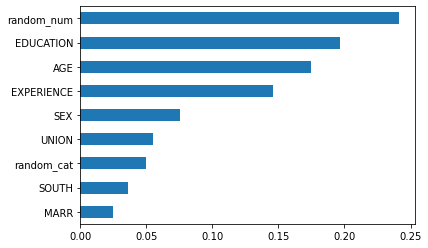

In [5]:
forest = ensemble.RandomForestRegressor(n_estimators=100)
forest.fit(X_train, y_train)

# Visualize the feature importance
importance = pd.Series(
    forest.feature_importances_,
    index=X_train.columns
).sort_values()
importance.plot(kind='barh')

### A more robust approach - permutation importance


As an alternative, the permutation importances of rf are computed
on a held out test set. This shows that the both random features `random_num`
and `random_cat` are not important, and that low cardinality features
such as `union` or `sex` are more important than `experience` here.


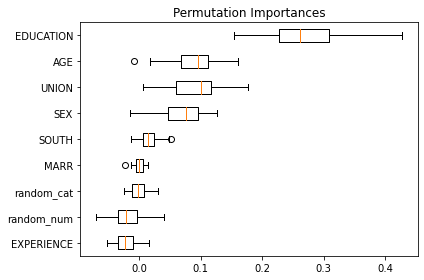

In [6]:
result = permutation_importance(
    forest, X_test, y_test, n_repeats=50,
    random_state=42, n_jobs=-1
)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(
    result.importances[sorted_idx].T,
    vert=False, labels=X_rand.columns[sorted_idx]
)
ax.set_title("Permutation Importances")
fig.tight_layout()
plt.show()

It is also possible to compute the permutation importances on the **training set**. This reveals that `random_num` gets a significantly higher importance ranking than when computed on the test set. The difference between those two plots is a confirmation that the RF model has enough capacity to use that random numerical feature to overfit.

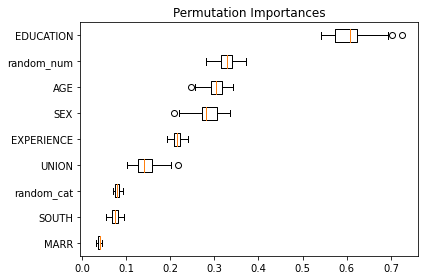

In [7]:
result = permutation_importance(
    forest, X_train, y_train, n_repeats=50,
    random_state=42, n_jobs=-1
)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(
    result.importances[sorted_idx].T,
    vert=False, labels=X_rand.columns[sorted_idx]
)
ax.set_title("Permutation Importances")
fig.tight_layout()
plt.show()


More on this in the [scikit-learn documentation](https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance.html).